# Using the bottleneck features of a pre-trained network: 90% accuracy in a minute

A more refined approach would be to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

We will use the VGG16 architecture, pre-trained on the ImageNet dataset --a model previously featured on this blog. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well. However, the method we present here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet.

Here's what the VGG16 architecture looks like:

![](vgg16_original.png)

Our strategy will be as follow: we will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features.

The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once. Note that this prevents us from using data augmentation.

You can find the full code for this experiment [here](https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069). You can get the weights file [from Github](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3).

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [3]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [4]:
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')

In [5]:
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_train = model.predict_generator(generator, nb_train_samples//batch_size)

Found 2000 images belonging to 2 classes.


In [6]:
np.save('bottleneck_features_train.npy', bottleneck_features_train)

In [7]:
generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples//batch_size)

Found 800 images belonging to 2 classes.


In [8]:
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

We can then load our saved data and train a small fully-connected model:

In [9]:
train_data = np.load('bottleneck_features_train.npy')
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

In [10]:
validation_data = np.load('bottleneck_features_validation.npy')
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

In [11]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Thanks to its small size, this model trains very quickly even on CPU (1s per epoch):

In [13]:
history = model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 2s - loss: 0.9032 - acc: 0.7390 - val_loss: 0.3305 - val_acc: 0.8438
Epoch 2/50
2000/2000 [==============================] - 1s - loss: 0.3319 - acc: 0.8510 - val_loss: 0.3065 - val_acc: 0.8762
Epoch 3/50
2000/2000 [==============================] - 1s - loss: 0.2924 - acc: 0.8840 - val_loss: 0.2459 - val_acc: 0.9000
Epoch 4/50
2000/2000 [==============================] - 1s - loss: 0.2437 - acc: 0.9010 - val_loss: 0.2408 - val_acc: 0.9050
Epoch 5/50
2000/2000 [==============================] - 1s - loss: 0.2134 - acc: 0.9170 - val_loss: 0.2709 - val_acc: 0.8988
Epoch 6/50
2000/2000 [==============================] - 1s - loss: 0.1745 - acc: 0.9350 - val_loss: 0.2636 - val_acc: 0.9087
Epoch 7/50
2000/2000 [==============================] - 1s - loss: 0.1502 - acc: 0.9440 - val_loss: 0.4747 - val_acc: 0.8562
Epoch 8/50
2000/2000 [==============================] - 1s - loss: 0.1464 - ac

In [18]:
model.save_weights('fc_model.h5')

We reach a validation accuracy of 0.90-0.91: not bad at all. This is definitely partly due to the fact that the base model was trained on a dataset that already featured dogs and cats (among hundreds of other classes).

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

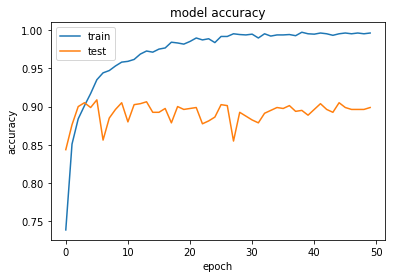

In [20]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

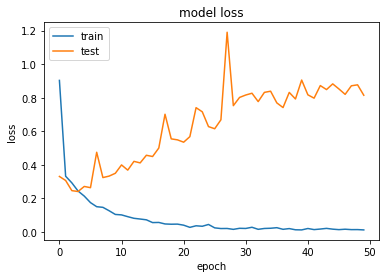

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');